### **Cement Composite Strength Prediction Model USing Machine Learning Technique**

##### **Author: Mukesh Magar**

In [1]:
# Importing Data Manipulation Libraries
import pandas as pd
import numpy as np
# Import Data Visualization Libraries
import seaborn as sns 
import matplotlib.pyplot as plt 
# Import Filter Warning Libraries
import warnings
warnings.filterwarnings('ignore')
# Import Logging
import logging
logging.basicConfig(level = logging.INFO,
                    format = '%(asctime)s - %(levelname)s - %(message)s',
                    filemode = 'w',
                    filename = 'model.log',force = True)
# Import Scikit Learn Libraries for Machine Learning Model Building
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,learning_curve,KFold
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
import xgboost
from xgboost import XGBRegressor
from sklearn.cluster import KMeans


# Multicolinearity test and treatment libraries
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA

In [2]:
# Creating Our First Log
logging.info('Import Dataset For Model Building...')

In [3]:
# Uploading Dataset Using Pandas Function
# Url Taken from Github 
url = 'https://raw.githubusercontent.com/mukeshmagar543/EnE_CementCompositeStrength_Model/refs/heads/main/notebooks/Concrete_Data.csv'

df = pd.read_csv(url)

df.sample(frac = 1)  # Shuffle Dataset

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
230,213.7,98.1,24.5,181.7,6.9,1065.8,785.4,14,30.39
90,389.9,189.0,0.0,145.9,22.0,944.7,755.8,3,40.60
755,540.0,0.0,0.0,173.0,0.0,1125.0,613.0,180,71.62
277,251.4,0.0,118.3,188.5,5.8,1028.4,757.7,56,36.97
6,380.0,95.0,0.0,228.0,0.0,932.0,594.0,365,43.70
...,...,...,...,...,...,...,...,...,...
179,362.6,189.0,0.0,164.9,11.6,944.7,755.8,91,79.30
181,389.9,189.0,0.0,145.9,22.0,944.7,755.8,91,82.60
756,540.0,0.0,0.0,173.0,0.0,1125.0,613.0,270,74.17
949,148.1,0.0,136.6,158.1,16.1,1001.8,830.1,28,17.96


In [4]:
# Creating Our First Log
logging.info('Dataset Imported Successfully For Model Building...')

In [5]:
# Checking Dataset Information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Cement (component 1)(kg in a m^3 mixture)              1030 non-null   float64
 1   Blast Furnace Slag (component 2)(kg in a m^3 mixture)  1030 non-null   float64
 2   Fly Ash (component 3)(kg in a m^3 mixture)             1030 non-null   float64
 3   Water  (component 4)(kg in a m^3 mixture)              1030 non-null   float64
 4   Superplasticizer (component 5)(kg in a m^3 mixture)    1030 non-null   float64
 5   Coarse Aggregate  (component 6)(kg in a m^3 mixture)   1030 non-null   float64
 6   Fine Aggregate (component 7)(kg in a m^3 mixture)      1030 non-null   float64
 7   Age (day)                                              1030 non-null   int64  
 8   Concrete compressive strength(MPa, megapascals)  

In [6]:
from collections import OrderedDict

stats = []

# Descriptive statistics
for col in df.columns:
    if df[col].dtype != 'object':
        numerical_stats = OrderedDict({
            'Feature': col,
            'Minimum': df[col].min(),
            'Maximum': df[col].max(),
            'Mean': df[col].mean(),
            'Mode': df[col].mode()[0] if not df[col].mode().empty else None,
            '25%': df[col].quantile(0.25),
            '75%': df[col].quantile(0.75),
            'IQR': df[col].quantile(0.75) - df[col].quantile(0.25),
            'Standard Deviation': df[col].std(),
            'Skewness': df[col].skew(),
            'Kurtosis': df[col].kurt()
        })
        stats.append(numerical_stats)

# Convert to DataFrame
report = pd.DataFrame(stats)

# Outlier Identification :
outlier_label = []
for col in report['Feature']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    LW = Q1 - 1.5 * IQR   # LW : Lower Whisker Line
    UW = Q3 + 1.5 * IQR   # UW : Upper Whisker Line
    outliers = df[(df[col] < LW) | (df[col] > UW)]
    if not outliers.empty:
        outlier_label.append("Has Outliers")
    else:
        outlier_label.append("No Outliers")

report["Outlier Comment"] = outlier_label

# Checking Report
report


,Feature,Minimum,Maximum,Mean,Mode,25%,75%,IQR,Standard Deviation,Skewness,Kurtosis,Outlier Comment
0,Cement (component 1)(kg in a m^3 mixture),102.00,540.0,281.167864,362.6,192.375,350.000,157.625,104.506364,0.509481,-0.520652,No Outliers
1,Blast Furnace Slag (component 2)(kg in a m^3 m...,0.00,359.4,73.895825,0.0,0.000,142.950,142.950,86.279342,0.800717,-0.508175,Has Outliers
2,Fly Ash (component 3)(kg in a m^3 mixture),0.00,200.1,54.188350,0.0,0.000,118.300,118.300,63.997004,0.537354,-1.328746,No Outliers
3,Water (component 4)(kg in a m^3 mixture),121.80,247.0,181.567282,192.0,164.900,192.000,27.100,21.354219,0.074628,0.122082,Has Outliers
4,Superplasticizer (component 5)(kg in a m^3 mix...,0.00,32.2,6.204660,0.0,0.000,10.200,10.200,5.973841,0.907203,1.411269,Has Outliers
5,Coarse Aggregate (component 6)(kg in a m^3 mi...,801.00,1145.0,972.918932,932.0,932.000,1029.400,97.400,77.753954,-0.040220,-0.599016,No Outliers
6,Fine Aggregate (component 7)(kg in a m^3 mixture),594.00,992.6,773.580485,594.0,730.950,824.000,93.050,80.175980,-0.253010,-0.102177,Has Outliers
7,Age (day),1.00,365.0,45.662136,28.0,7.000,56.000,49.000,63.169912,3.269177,12.168989,Has Outliers
8,"Concrete compressive strength(MPa, megapascals)",2.33,82.6,35.817961,33.4,23.710,46.135,22.425,16.705742,0.416977,-0.313725,Has Outliers


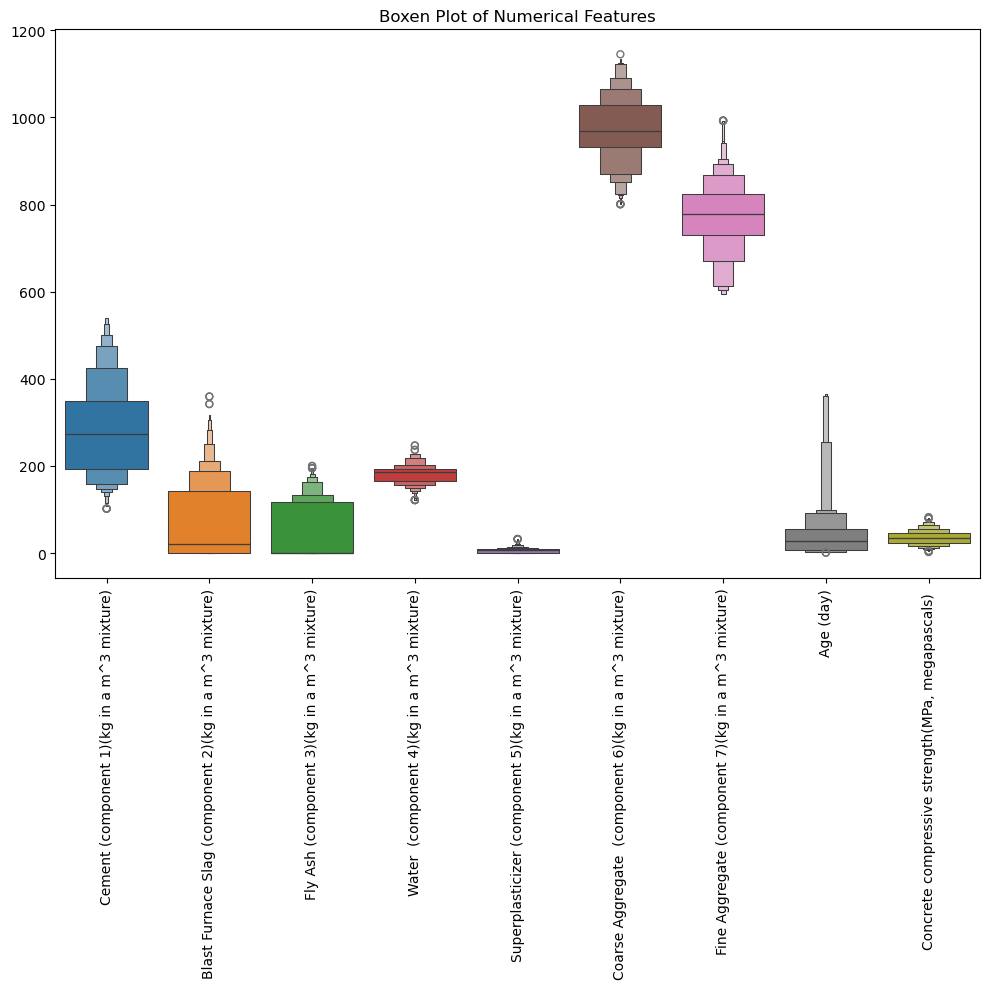

In [7]:
# Checking BoxenPlot 
plt.figure(figsize=(10, 10))
sns.boxenplot(data= df)

plt.xticks(rotation = 90)  
plt.title("Boxen Plot of Numerical Features")
plt.tight_layout()
plt.show()

In [8]:
# Replace Outliers with Median Statergy

for col in df.select_dtypes(include='number').columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outliers = (df[col] < lower_bound) | (df[col] > upper_bound)
    outlier_count = outliers.sum()

    if outlier_count > 0:
        replacement = df[col].median()  
        df.loc[outliers, col] = replacement
        print(f"Replaced {outlier_count} outliers in '{col}' with median.")
    else:
        print(f"No outliers found in '{col}'.")

No outliers found in 'Cement (component 1)(kg in a m^3 mixture)'.
Replaced 2 outliers in 'Blast Furnace Slag (component 2)(kg in a m^3 mixture)' with median.
No outliers found in 'Fly Ash (component 3)(kg in a m^3 mixture)'.
Replaced 9 outliers in 'Water  (component 4)(kg in a m^3 mixture)' with median.
Replaced 10 outliers in 'Superplasticizer (component 5)(kg in a m^3 mixture)' with median.
No outliers found in 'Coarse Aggregate  (component 6)(kg in a m^3 mixture)'.
Replaced 5 outliers in 'Fine Aggregate (component 7)(kg in a m^3 mixture)' with median.
Replaced 59 outliers in 'Age (day)' with median.
Replaced 4 outliers in 'Concrete compressive strength(MPa, megapascals) ' with median.


In [9]:
# Creating Our First Log
logging.info('Outlier Detection and Replacing of Outlier Activity Done Using IQR Method.')

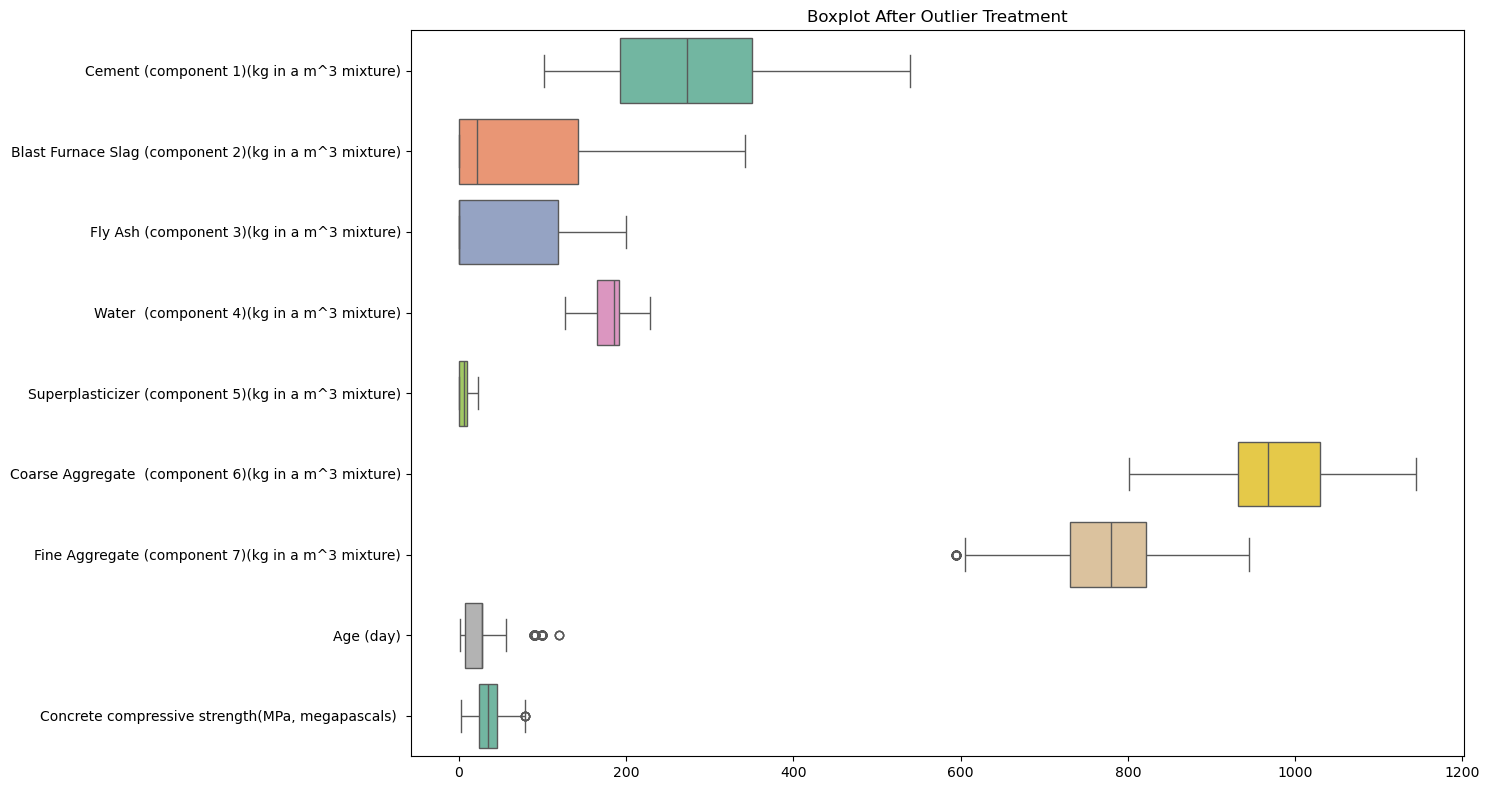

In [10]:
# Set figure size
plt.figure(figsize=(15, 8))

# Create boxplot for all numerical columns
sns.boxplot(data=df, orient='h', palette='Set2')

# Set title
plt.title('Boxplot After Outlier Treatment')
plt.tight_layout()
plt.show()

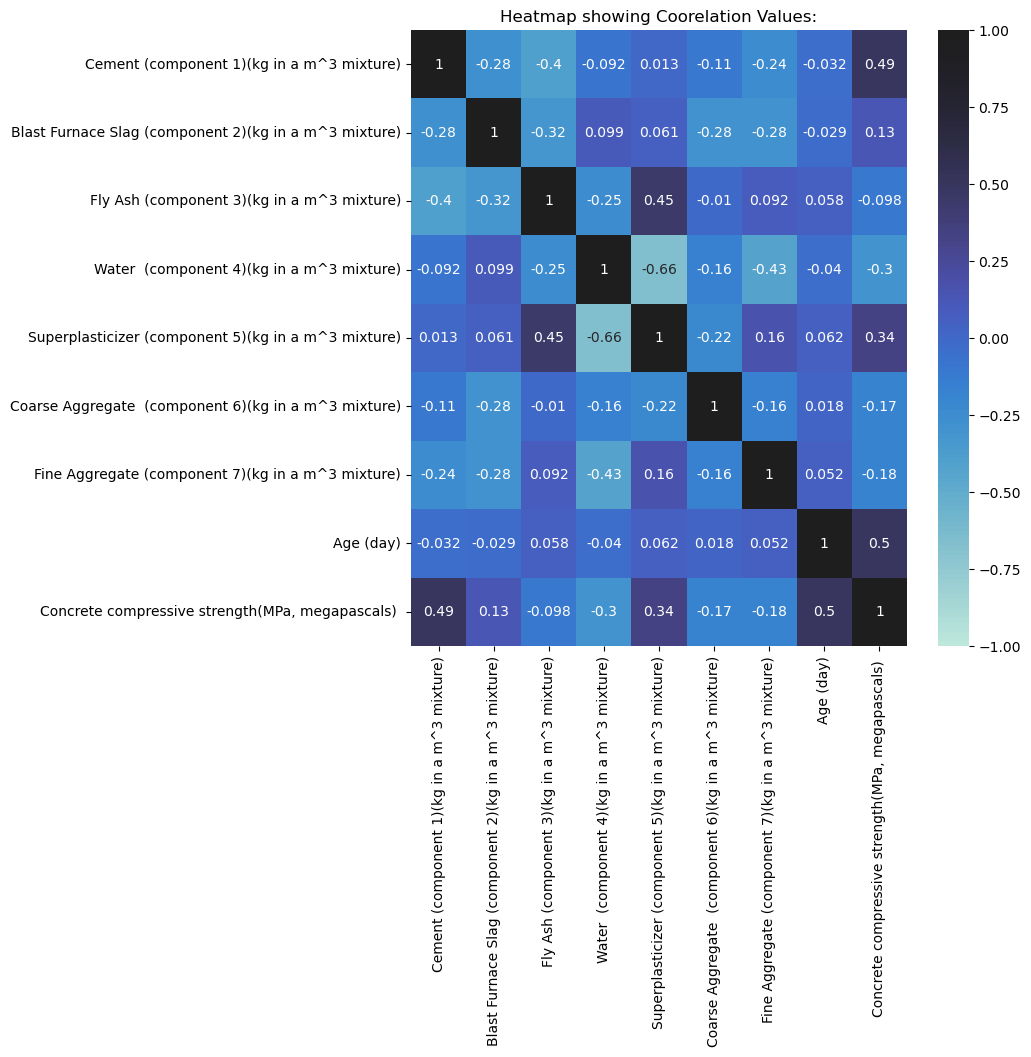

In [11]:
# Checking Correlation 
corr = df.corr()
df.ax = plt.subplots(figsize = (8,8))
sns.heatmap(corr,annot = True,center = True,vmax= 1,vmin = -1)
plt.title('Heatmap showing Coorelation Values:')
plt.show()

In [12]:
df.columns

Index(['Cement (component 1)(kg in a m^3 mixture)',
       'Blast Furnace Slag (component 2)(kg in a m^3 mixture)',
       'Fly Ash (component 3)(kg in a m^3 mixture)',
       'Water  (component 4)(kg in a m^3 mixture)',
       'Superplasticizer (component 5)(kg in a m^3 mixture)',
       'Coarse Aggregate  (component 6)(kg in a m^3 mixture)',
       'Fine Aggregate (component 7)(kg in a m^3 mixture)', 'Age (day)',
       'Concrete compressive strength(MPa, megapascals) '],
      dtype='object')

In [13]:
# Checking VIF:
def calculate_vif(dataset):
    vif = pd.DataFrame()
    vif['features'] = dataset.columns
    vif['VIF_Values'] = [variance_inflation_factor(dataset.values,i) for i in range(dataset.shape[1])]
    vif['VIF_Values'] = round(vif['VIF_Values'], 2)
    vif = vif.sort_values(by = 'VIF_Values', ascending=False)
    return (vif)

calculate_vif(df.drop('Concrete compressive strength(MPa, megapascals) ',axis = 1))

,features,VIF_Values
5,Coarse Aggregate (component 6)(kg in a m^3 mi...,86.94
3,Water (component 4)(kg in a m^3 mixture),81.96
6,Fine Aggregate (component 7)(kg in a m^3 mixture),68.66
0,Cement (component 1)(kg in a m^3 mixture),14.29
4,Superplasticizer (component 5)(kg in a m^3 mix...,5.72
2,Fly Ash (component 3)(kg in a m^3 mixture),4.42
1,Blast Furnace Slag (component 2)(kg in a m^3 m...,3.34
7,Age (day),2.37


In [14]:
# Creating Our First Log
logging.info('Correlation Matrix plotted and PCA Technique Started....')

In [15]:
# Using PCA Concept:

# Step 1: Standardize the data

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df)

# Step 2: Determine number of components to retain 90% variance

for i in range(1, df.shape[1] + 1):
    pca = PCA(n_components=i)
    pca.fit(X_scaled)
    evr = np.cumsum(pca.explained_variance_ratio_)
    if evr[i - 1] >= 0.90:
        pcs = i
        break

print("Explained Variance Ratio:", evr)
print("Number of components selected:", pcs)

# Step 3: Apply PCA

pca = PCA(n_components=pcs)
pca_data = pca.fit_transform(X_scaled)

# Step 4: Create DataFrame

pca_columns = [f'PC{j+1}' for j in range(pcs)]
pca_df = pd.DataFrame(pca_data, columns=pca_columns)

# Step 5: Join Target Column with PCA:

pca_df = pca_df.join(df['Concrete compressive strength(MPa, megapascals) '], how = 'left')

pca_df

Explained Variance Ratio: [0.27922213 0.47591513 0.63302735 0.75476394 0.86410929 0.95852334]
Number of components selected: 6


,PC1,PC2,PC3,PC4,PC5,PC6,"Concrete compressive strength(MPa, megapascals)"
0,-0.370604,0.227445,-0.537088,-0.003894,-0.253639,0.163116,34.445
1,-0.381428,0.431252,-0.554946,-0.098776,-0.239169,0.197649,61.890
2,-0.630790,-0.073797,0.168205,-0.351106,-0.304745,-0.167294,40.270
3,-0.631105,-0.067734,0.168185,-0.353454,-0.304497,-0.167235,41.050
4,-0.303858,-0.119720,0.138778,0.050716,0.255380,0.010240,44.300
...,...,...,...,...,...,...,...
1025,0.156394,0.160053,0.253019,0.042591,-0.131460,-0.170938,44.280
1026,0.321856,0.065753,0.027292,0.141070,-0.191079,-0.499024,31.180
1027,0.217121,-0.242009,0.397681,-0.020291,-0.019839,-0.171280,23.700
1028,-0.105050,0.005853,0.382897,0.148551,0.162517,0.286277,32.770


In [16]:
# Creating Our First Log
logging.info('Model Building Started............')

In [17]:
# Model Building

def train_and_test_split(data, tcol, testSize=0.3, randomState=3):
    X = data.drop(tcol,axis=1)
    y = data[tcol]
    return train_test_split(X,y,test_size = testSize,random_state=randomState)

def model_builder(model_name, model, data, t_col):
    X_train,X_test,y_train,y_test = train_and_test_split(data,t_col)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    result = [model_name, rmse, r2]
    return result

model_builder(model_name='LinearRegression',model=LinearRegression(),data=pca_df,t_col='Concrete compressive strength(MPa, megapascals) ')

['LinearRegression', 5.677664698719992, 0.8899623746061738]

In [18]:
def multiple_models(data, t_col):
    col_names=['Model Name','rmse','r2_score']
    result = pd.DataFrame(columns = col_names)
    result.loc[len(result)] = model_builder('Linear Regression',LinearRegression(),data,t_col)
    result.loc[len(result)] = model_builder('Lasso',Lasso(),data,t_col)
    result.loc[len(result)] = model_builder('Ridge',Ridge(),data,t_col)
    result.loc[len(result)] = model_builder('Decision Tree',DecisionTreeRegressor(),data,t_col)
    result.loc[len(result)] = model_builder('SVR',SVR(),data,t_col)
    result.loc[len(result)] = model_builder('KNN',KNeighborsRegressor(),data,t_col)
    result.loc[len(result)] = model_builder('Random Forest',RandomForestRegressor(),data,t_col)
    result.loc[len(result)] = model_builder('Gradient Boost',GradientBoostingRegressor(),data,t_col)
    result.loc[len(result)] = model_builder('ADA Boost',AdaBoostRegressor(),data,t_col)
    result.loc[len(result)] = model_builder('XG Boost',XGBRegressor(),data,t_col)
    return result.sort_values(by = 'r2_score', ascending=False)

multiple_models(pca_df, 'Concrete compressive strength(MPa, megapascals) ')

,Model Name,rmse,r2_score
9,XG Boost,3.707997,0.953067
6,Random Forest,4.131093,0.941745
7,Gradient Boost,4.384408,0.934382
5,KNN,5.652533,0.890934
0,Linear Regression,5.677665,0.889962
2,Ridge,5.722516,0.888217
8,ADA Boost,5.801973,0.885091
3,Decision Tree,5.888520,0.881638
4,SVR,6.328422,0.863292
1,Lasso,8.363783,0.761215


In [19]:
def k_fold_cv(X, y , fold= 10):
    score_LR = cross_val_score(LinearRegression(), X, y ,cv = fold)
    score_LS = cross_val_score(Lasso(), X, y, cv = fold)
    score_RD = cross_val_score(Ridge(), X, y, cv = fold)
    score_DTR = cross_val_score(DecisionTreeRegressor(), X, y, cv = fold)
    score_SVR = cross_val_score(SVR(), X, y ,cv = fold)
    score_KNN = cross_val_score(KNeighborsRegressor(), X, y ,cv = fold)
    score_RF = cross_val_score(RandomForestRegressor(), X, y ,cv = fold)
    score_GB = cross_val_score(GradientBoostingRegressor(), X, y, cv = fold)
    score_ADA = cross_val_score(AdaBoostRegressor(), X, y, cv = fold)
    score_XG = cross_val_score(XGBRegressor(), X, y, cv = fold)
    
    
    
    model_name = ['Linear Regression','Lasso','Ridge','DTR','SVR','KNN','Random Forest','Gradient Boost','ADA Boost','XG' ]
    scores = [score_LR,score_LS,score_RD,score_DTR,score_SVR,score_KNN,score_RF,score_GB,score_ADA,score_XG]
    result = []
    for i in range(len(model_name)):
        score_mean = np.mean(scores[i])
        score_std = np.std(scores[i])
        m_name = model_name[i]
        temp = [m_name,score_mean,score_std]
        result.append(temp)
    k_fold_df = pd.DataFrame(result,columns = ['Model Name','CV Accuracy','CV STD'])
    return k_fold_df.sort_values('CV Accuracy',ascending= False)


k_fold_cv(pca_df.drop('Concrete compressive strength(MPa, megapascals) ',axis=1), pca_df['Concrete compressive strength(MPa, megapascals) '])

,Model Name,CV Accuracy,CV STD
7,Gradient Boost,0.844615,0.149859
9,XG,0.832815,0.210426
6,Random Forest,0.820785,0.225276
0,Linear Regression,0.800141,0.159829
2,Ridge,0.800018,0.159464
8,ADA Boost,0.757298,0.180619
3,DTR,0.698276,0.314417
4,SVR,0.687752,0.183412
5,KNN,0.666863,0.264973
1,Lasso,0.641080,0.263170


In [20]:
def tuning(X, y , fold = 10):
    #Generally we dont do hyperparameter tuning for all the models, becuase if we train lasso and ridge at max it will give.
    #Parameters Grid for tuning
    param_LAS = {'alpha' : [1e-15, 1e-13, 1e-11, 1e-9,1e-7, 1e-5,1e-3, 1e-1, 0,1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100,200,300,400,500]}
    param_KNN = {'n_neighbors' : [1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100]}
    param_DTR = {'max_depth' : [3,5,7,9,10,12,14,16] , 'max_features' : ['auto', 'log2', 'sqrt', 2,3,4,5,6]}
    param_SVR = {'gamma' : ['scale' , 'auto'], 'C' : [0.5 , 1]}
    param_ADB = {'learning_rate' : [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]}
    param_GB = {'alpha' : [0.1,0.3,0.5,0.9]}
    param_XGB = {'eta' : [0.1,0.2,0.3,0.4,0.5], 'max_depth' : [3,5,7,9,10,12,14,15,16], 'gamma' : [0,10,20,30,40,50,60,70,80,90,100,200,300,400,500], 'reg_lambda' : [0,1]}
    param_RF = {'max_depth' : [3,5,7,8,9,10,12,14,16], 'max_features' : ['auto', 'log2', 'sqrt', 2,3,4,5,6]}
#hyperparameter Tuning
    tune_LAS = GridSearchCV(Lasso(), param_LAS, cv = fold)
    tune_RID = GridSearchCV(Ridge(), param_LAS , cv = fold)
    tune_KNN = GridSearchCV(KNeighborsRegressor() , param_KNN , cv = fold)
    tune_DT = GridSearchCV(DecisionTreeRegressor(), param_DTR , cv = fold)
    tune_SVR = GridSearchCV(SVR(), param_SVR , cv = fold)
    tune_ADB = GridSearchCV(AdaBoostRegressor() , param_ADB , cv = fold)
    tune_GB = GridSearchCV(GradientBoostingRegressor() , param_GB , cv = fold)
    tune_XGB = GridSearchCV(XGBRegressor() , param_XGB , cv = fold)
    tune_RF = GridSearchCV(RandomForestRegressor() , param_RF , cv = fold)
    
    #Fitting X and Y
    tune_LAS.fit(X,y)
    tune_RID.fit(X,y)
    tune_KNN.fit(X,y)
    tune_DT.fit(X,y)
    tune_SVR.fit(X,y)
    tune_ADB.fit(X,y)
    tune_GB.fit(X,y)
    tune_XGB.fit(X,y)
    tune_RF.fit(X,y)
    
    tune = [tune_LAS, tune_RID, tune_KNN, tune_DT, tune_SVR, tune_ADB, tune_GB, tune_XGB, tune_RF]
    models = ['Lasso', 'Ridge', 'KNN' , 'DTR', 'SVR' , 'ADBR', 'GBR', 'XGBR' , 'RFR']
    
    for i in range(len(tune)):
        print('models:', models[i])
        print('best parameters :', tune[i].best_params_)

    
tuning(pca_df.drop('Concrete compressive strength(MPa, megapascals) ',axis=1), pca_df['Concrete compressive strength(MPa, megapascals) '])

models: Lasso
best parameters : {'alpha': 0.001}
models: Ridge
best parameters : {'alpha': 0.1}
models: KNN
best parameters : {'n_neighbors': 3}
models: DTR
best parameters : {'max_depth': 7, 'max_features': 4}
models: SVR
best parameters : {'C': 1, 'gamma': 'auto'}
models: ADBR
best parameters : {'learning_rate': 1}
models: GBR
best parameters : {'alpha': 0.5}
models: XGBR
best parameters : {'eta': 0.3, 'gamma': 0, 'max_depth': 3, 'reg_lambda': 1}
models: RFR
best parameters : {'max_depth': 14, 'max_features': 5}


In [21]:
def cv_post_hpt(X,y, fold = 5):
    score_LR = cross_val_score(LinearRegression(), X, y, cv = fold)
    score_LS = cross_val_score(Lasso(alpha = 0.1), X, y ,cv = fold)
    score_RD = cross_val_score(Ridge(alpha = 6 ), X , y , cv = fold)
    score_DTR = cross_val_score(DecisionTreeRegressor(max_depth = 16), X , y , cv = fold)
    score_SVR= cross_val_score(SVR(C = 1), X , y , cv = fold)
    score_RandomForest = cross_val_score(RandomForestRegressor(max_depth = 14, max_features = 4), X , y , cv = fold)
    score_KNN = cross_val_score(KNeighborsRegressor(n_neighbors = 4), X , y , cv = fold)
    score_GBoost = cross_val_score(GradientBoostingRegressor(alpha = 0.9), X , y , cv = fold)
    score_XGBoost = cross_val_score(XGBRegressor(eta = 0.2,max_depth = 5, reg_lambda = 0, gamma = 0), X , y , cv = fold)
    score_AdaBoost = cross_val_score(AdaBoostRegressor(learning_rate = 1), X , y , cv = fold)
    
    
    model_name = ['Linear Regression', 'Lasso', 'Ridge', 'DTR' , 'SVR' , 'Random Forest' , 'KNN', 'Gboost' , 'XGBoost' , 'AdaBoost']
    scores = [score_LR, score_LS, score_RD, score_DTR, score_SVR,score_RandomForest, score_KNN, score_GBoost, score_XGBoost, score_AdaBoost ]
    result = []
    for i in range(len(model_name)):
        score_mean = np.mean(scores[i])
        score_std = np.std(scores[i])
        m_name = model_name[i]
        temp = [m_name , score_mean , score_std]
        result.append(temp)
    k_fold_df = pd.DataFrame(result , columns = ['Model Name' , 'CV Accuracy' , 'CV STD'])
    return k_fold_df.sort_values('CV Accuracy', ascending = False)


cv_post_hpt(pca_df.drop('Concrete compressive strength(MPa, megapascals) ',axis=1), pca_df['Concrete compressive strength(MPa, megapascals) '])

,Model Name,CV Accuracy,CV STD
7,Gboost,0.846128,0.071928
1,Lasso,0.830010,0.066349
5,Random Forest,0.828063,0.080078
2,Ridge,0.821688,0.055219
0,Linear Regression,0.821388,0.067965
8,XGBoost,0.813470,0.112086
9,AdaBoost,0.794147,0.066776
6,KNN,0.698402,0.092425
3,DTR,0.686312,0.146375
4,SVR,0.656638,0.173702


<Axes: xlabel='Concrete compressive strength(MPa, megapascals) ', ylabel='Concrete compressive strength(MPa, megapascals) '>

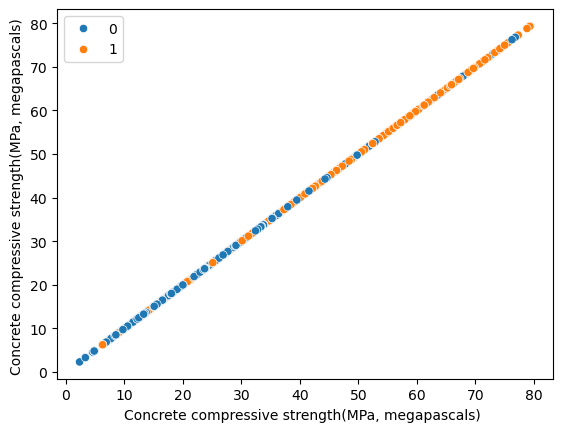

In [22]:
# Cluster Appraoch:

kmeans = KMeans(n_clusters = 2, random_state = 2)
clusters = kmeans.fit_predict(df.drop('Concrete compressive strength(MPa, megapascals) ', axis = 1))
sns.scatterplot(x = df['Concrete compressive strength(MPa, megapascals) '], y = df['Concrete compressive strength(MPa, megapascals) '], hue = clusters)

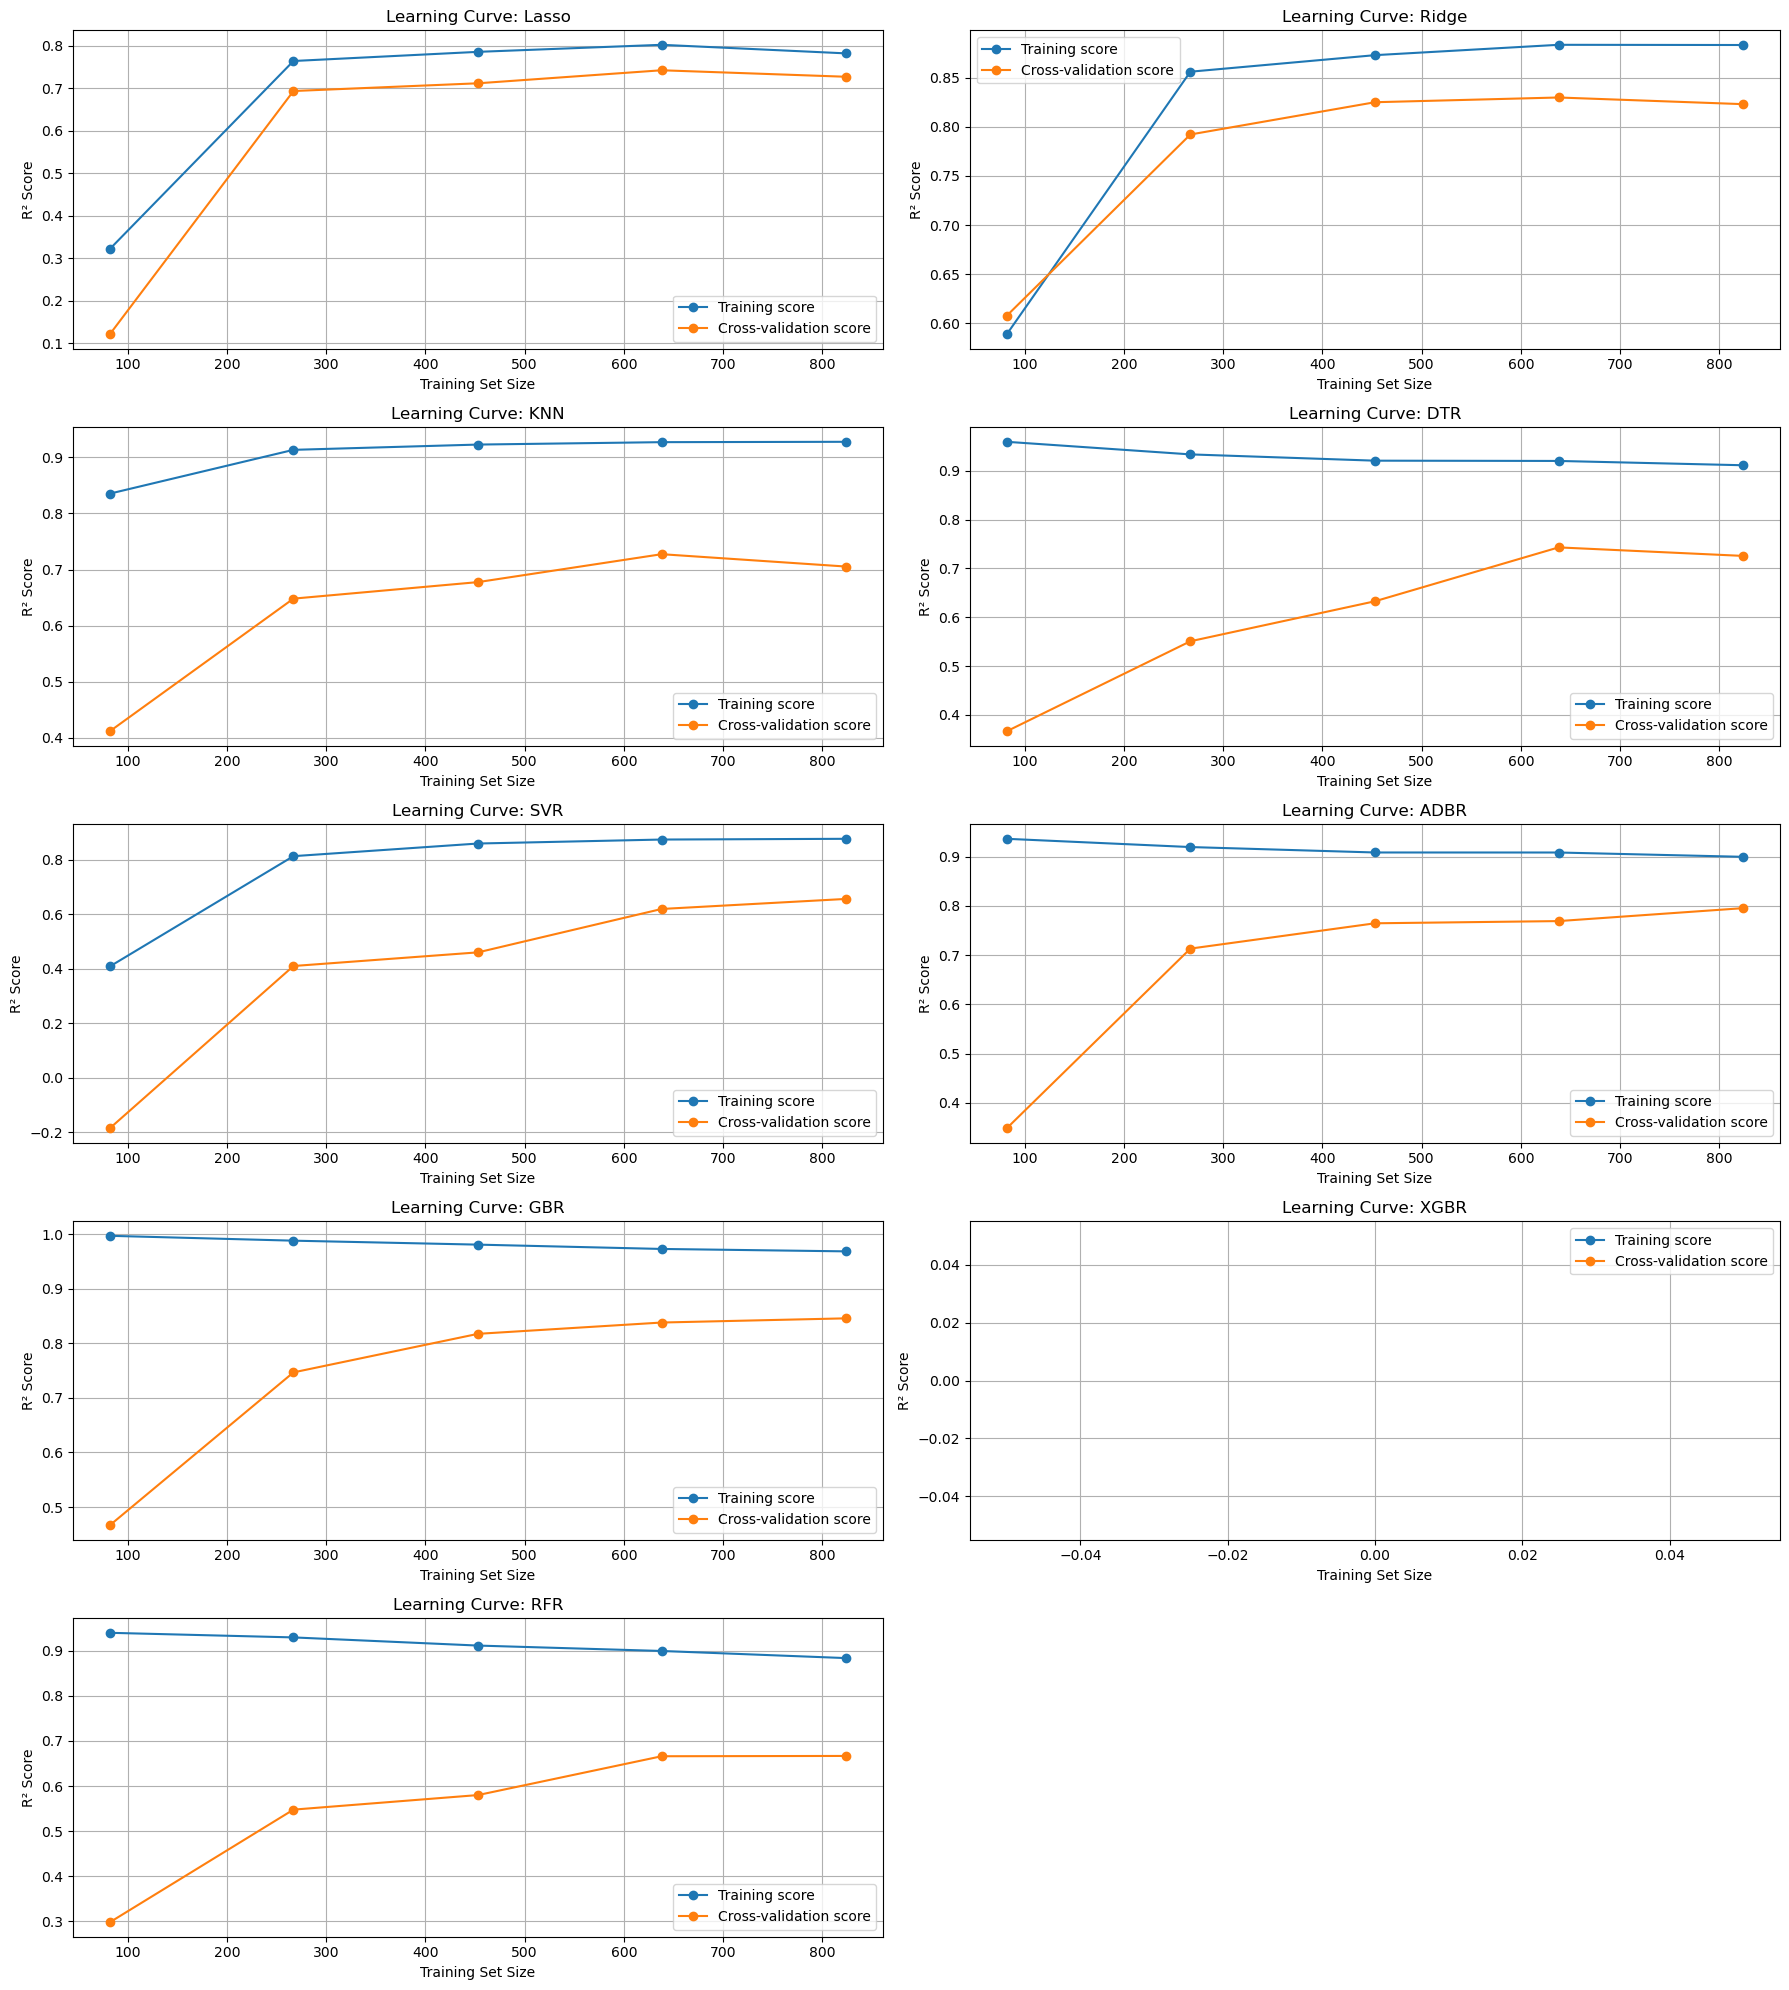

In [23]:
# Plotting Learning Rate 
# List of models
models = {
    'Lasso': Lasso(alpha=1),
    'Ridge': Ridge(alpha=1),
    'KNN': KNeighborsRegressor(n_neighbors=5),
    'DTR': DecisionTreeRegressor(max_depth=5),
    'SVR': SVR(C=1, gamma='scale'),
    'ADBR': AdaBoostRegressor(learning_rate=1),
    'GBR': GradientBoostingRegressor(alpha=0.1),
    'XGBR': XGBRegressor(eta=0.1, max_depth=3, verbosity=0),
    'RFR': RandomForestRegressor(max_depth=5, max_features='sqrt')
}

X = pca_df.drop('Concrete compressive strength(MPa, megapascals) ', axis=1)
y = pca_df['Concrete compressive strength(MPa, megapascals) ']

# Plot learning curves
plt.figure(figsize=(18, 20))
for i, (name, model) in enumerate(models.items()):
    plt.subplot(5, 2, i+1)
    
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 5),
        scoring='r2'
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.plot(train_sizes, train_scores_mean, 'o-', label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', label='Cross-validation score')
    plt.title(f'Learning Curve: {name}')
    plt.xlabel('Training Set Size')
    plt.ylabel('R² Score')
    plt.legend(loc='best')
    plt.grid()

plt.tight_layout()
plt.show()

In [24]:
# Creating Our First Log
logging.info('Best Parameters Now Idenfied and model is saved as pickle file in notebook folder..')

In [25]:
# Saving Pickle Model file 
import pickle

X_pca = pca_df.drop('Concrete compressive strength(MPa, megapascals) ', axis=1)
y = pca_df['Concrete compressive strength(MPa, megapascals) ']


best_xgb = XGBRegressor(
    n_estimators=150,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    random_state=42
)

# Train on PCA data
best_xgb.fit(X_pca, y)  # X_pca is PCA-transformed features, y is the target

# Save the XGBoost model
with open("best_xgb_model.pkl", "wb") as f:
    pickle.dump(best_xgb, f)

print("XGBoost model saved as 'best_xgb_model.pkl'")

XGBoost model saved as 'best_xgb_model.pkl'
